<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/factorpricingmodel/factor-pricing-model-risk-model/blob/main/examples/notebook/crypto_empirical_analysis_alpha_sizing_rules.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/factorpricingmodel/factor-pricing-model-risk-model/blob/main/examples/notebook/crypto_empirical_analysis_alpha_sizing_rules.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Empirical Analysis of Alpha Sizing Rules in Cryptocurrency

The notebook visits a few alpha sizing rules, e.g. Mean-Variance rule, with several signals. It also demonstrates the usage of factor risk model to improve the performance of the Mean-Variance rule.

### Requirements

- Python 3.6+
- [Jupyter](http://jupyter.org/)
- [pandas](http://pandas.pydata.org/)
- [numpy](http://www.numpy.org/)
- [factor-pricing-model-risk-model](https://factor-pricing-model-risk-model.readthedocs.io/en/latest/index.html)

In [ ]:
!pip install matplotlib factor-pricing-model-risk-model factor-pricing-model-universe

In [ ]:
from functools import partial

import numpy as np
import pandas as pd
from IPython.display import display

from fpm_risk_model.dataset.crypto import (
    download_sample_data_model_universe,
)
from fpm_universe.pipeline import rolling_validity, ranking
from fpm_risk_model.rolling_factor_risk_model import RollingFactorRiskModel
from fpm_risk_model.rolling_risk_model import RollingRiskModel
from fpm_risk_model.statistical import PCA
from fpm_risk_model import RollingCovarianceEstimator

# Download crypto price and volume data

Cryptocurrencies with a top 1000 market cap are downloaded. Due to the volatile
price changes in the market, all the daily returns beyond +/-20% are clipped.

In [ ]:
sample_data_model_universe = download_sample_data_model_universe()
prices = sample_data_model_universe["prices"].shift()
returns = (
    sample_data_model_universe["returns"]
    .shift()
    .clip(lower=-0.2, upper=0.2)
)
volumes = sample_data_model_universe["volumes"].shift()
volumes_usd = volumes * prices

# Model universe creation

Instruments are selected for the model universe based on the following criteria:

- 80% valid returns in the past 6 months
- Top 50% trading volumes in USD
- Minimum annual volatility of 5% (filtering out stablecoins)

In the meantime, the estimation universe is also defined in the later section on risk model generation. The only difference in the selection of the estimation universe is that only those with top 10%, rather than 50%, trading volumes in USD are included.

<Axes: title={'center': 'Number of instruments in universes'}, xlabel='datetime'>

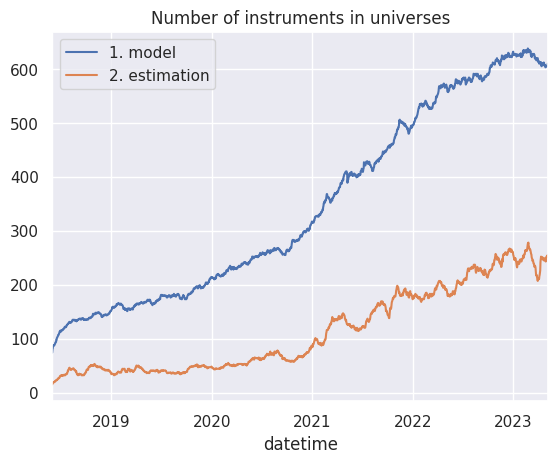

In [ ]:
rolling_validity_universe = rolling_validity(
    values=returns.where(returns.abs() > 0.0),
    threshold_pct=0.8,
    rolling_window=180,
    tolerance_timeframes=5,
    start_datetime="2018-06-01",
    last_datetime=returns.index[-1],
    frequency="D",
)
non_stable_validity_universe = ((returns.rolling(30).std() * np.sqrt(365.25)) > 0.05).loc["2018-06-01":]
ranking_validity_estimation_universe = ranking(
    values=volumes,
    threshold_pct=0.1,
    tolerance_timeframes=30,
    start_datetime="2018-06-01",
    last_datetime=returns.index[-1],
    frequency="D",
)
ranking_validity_model_universe = ranking(
    values=volumes,
    threshold_pct=0.5,
    tolerance_timeframes=30,
    start_datetime="2018-06-01",
    last_datetime=returns.index[-1],
    frequency="D",
)
estimation_validity = rolling_validity_universe & non_stable_validity_universe & ranking_validity_estimation_universe
validity = model_validity = rolling_validity_universe & non_stable_validity_universe & ranking_validity_model_universe
pd.concat({
    '1. model': model_validity.sum(axis=1),
    '2. estimation': estimation_validity.sum(axis=1),
}, axis=1).plot(title="Number of instruments in universes")

# Magical alpha

Let's create a magical alpha with the assumption that we can predict 100% on the total return next month and assign it with the average forecasted next month return on each day.

In [ ]:
yyyy_mm = pd.Series(returns.index.map(lambda x: x.strftime("%Y-%m")), index=returns.index)
month_days = pd.Series(1.0, index=returns.index).groupby(returns.index.map(lambda x: x.strftime("%Y-%m"))).sum()
forecast_daily_returns = returns.groupby(returns.index.map(lambda x: x.strftime("%Y-%m"))).sum().div(month_days, axis=0)
magic_score = pd.merge(
    left=yyyy_mm.to_frame(name="yyyy_mm"),
    right=forecast_daily_returns,
    left_on="yyyy_mm",
    right_index=True,
    how="left",
)
del magic_score["yyyy_mm"]

Also, we define a pipeline to normalize the scores in the cross section and clip the z-scores by +/-3.0

In [ ]:
def normalize_xs(
  score,
  validity,
  winsorization=3.0,
  max_iter=20,
  atol=1e-4
):
  score = score.reindex_like(validity).where(validity)
  for idx in range(max_iter):
    xs_mean = score.mean(axis=1)
    xs_std = score.std(axis=1)
    xs_mean_err = xs_mean.abs().fillna(0.0)
    xs_std_err = (xs_std - 1.0).abs().fillna(0.0)
    if ((xs_mean_err < atol) & (xs_std_err < atol)).all():
      break
    score = score.sub(xs_mean, axis=0).div(xs_std, axis=0).clip(upper=winsorization, lower=-winsorization)

  assert idx != max_iter - 1, (
    f"Score does not converage after {max_iter} iterations. "
    f"Max mean error: {xs_mean_err.max()}. "
    f"Max std error: {xs_std_err.max()}"
  )

  return score

In [ ]:
magic_score = normalize_xs(score=magic_score, validity=validity)
magic_score.tail()

,ALPINE_Alpine-F1-Team-Fan-Token,VRSC_VerusCoin,FRAX_Frax,ZIL_Zilliqa,AION_Aion,CAKE_PancakeSwap,MBOX_MOBOX,BIDR_BIDR,HIGH_Highstreet,ANKR_Ankr,...,SWAP_TrustSwap,SRM_Serum,DFYN_Dfyn-Network,PRE_Presearch,GMX11857_GMX,VEGA_Vega-Protocol,THN_Throne,PART_Paricle-Technology,CCD_Concordium,HEZ_Hermez-Network
datetime,,,,,,,,,,,,,,,,,,,,,
2023-05-03,-0.374576,NaN,NaN,-0.515495,NaN,-0.593667,0.304838,NaN,-1.450140,-0.452138,...,-0.063156,-0.274459,2.003535,NaN,0.562630,NaN,NaN,NaN,0.300323,NaN
2023-05-04,-0.367738,NaN,NaN,-0.506999,NaN,-0.584251,0.303681,NaN,-1.430645,-0.444388,...,-0.059982,-0.268799,1.982389,NaN,0.558440,NaN,NaN,NaN,0.299219,NaN
2023-05-05,-0.371875,NaN,NaN,-0.509912,NaN,-0.586484,0.293642,NaN,-1.425438,-0.447851,...,-0.066825,-0.273806,1.957592,NaN,0.546161,NaN,NaN,NaN,0.289219,NaN
2023-05-06,-0.372054,NaN,NaN,-0.510197,NaN,-0.586829,0.293973,NaN,-1.426426,-0.448089,...,-0.066770,-0.273910,1.959200,NaN,0.546686,NaN,NaN,NaN,0.289547,NaN
2023-05-07,-0.373284,NaN,NaN,-0.511723,NaN,-0.588519,0.294173,NaN,-1.429919,-0.449481,...,-0.067344,-0.274929,1.962974,NaN,0.547428,NaN,NaN,NaN,0.289737,NaN


# Alpha sizing

We will walk through a few alpha sizing rules in this section.

First of all, assume that all the sized positions are traded in a dollar neutral manner without leverage (i.e. leverage = 1.0).

The function `dollar_neutral` demeans the sized positions, and the gross sum of positions is equal to 1.0

In [ ]:
def dollar_neutral(alpha, leverage=1.0):
  alpha = alpha.sub(alpha.mean(axis=1), axis=0)
  alpha = alpha.div(alpha.abs().sum(axis=1), axis=0) * leverage
  return alpha

Then, the following alpha sizing appraoches will be studied

1. **Proportional**: This method involves allocating assets in the same direction and magnitude as the alpha, with adjustments for dollar neutrality and leverage.

2. **Proportional Signed (1/N rule)**: In this approach, only the sign (positive or negative) of the alpha is considered, and the allocation is divided equally between the long and short sides.

3. **Risk Parity**: This method divides the alpha by the asset's volatility. The rationale behind this is to normalize the alpha with respect to volatility, resulting in dollar exposure per 1% of volatility.

4. **Mean Variance**: Alpha is divided by the asset's variance

5. **Mean Variance (Shrink)**: Alpha divided by the shrunken asset variance `(1 - p) x variance + p x benchmark variance`. For instance, 75% shrink means 25% asset variance and 75% benchmark variance)



In [ ]:
def alpha_sizing(
    score,
    returns,
    validity,
    benchmark_variance,
    est_window=180,
    leverage=1.0,
    ic=1.0,
):
  # Asset volatility
  volatility = returns.rolling(est_window, min_periods=int(est_window * 0.8)).std()
  variance = volatility ** 2
  # Alpha = Score * Volatility * IC
  alpha = (score * volatility * ic).reindex_like(validity)
  # proportional = Alpha
  proportional_alpha = dollar_neutral(alpha, leverage)
  # proportional signed = 1 / (# Positive alpha) - 1 / (# Negative alpha)
  proportional_signed_alpha = (
      (alpha > 0.0).div((alpha > 0.0).sum(axis=1), axis=0).fillna(0.0)
      - (alpha < 0.0).div((alpha < 0.0).sum(axis=1), axis=0).fillna(0.0)
  )
  proportional_signed_alpha = dollar_neutral(proportional_signed_alpha, leverage)
  # Risk parity = alpha / volatility
  risk_parity_alpha = alpha / volatility
  risk_parity_alpha = dollar_neutral(risk_parity_alpha, leverage)
  # Mean variance = alpha / variance
  mean_variance_alpha = alpha / variance
  mean_variance_alpha = dollar_neutral(mean_variance_alpha, leverage)
  # Shrinked 75% mean variance
  shrinked_75_mean_variance_alpha = alpha / (0.25 * variance.add(0.75 * benchmark_variance, axis=0))
  shrinked_75_mean_variance_alpha = dollar_neutral(shrinked_75_mean_variance_alpha, leverage)
  # Shrinked 50% mean variance
  shrinked_50_mean_variance_alpha = alpha / (0.50 * variance.add(0.50 * benchmark_variance, axis=0))
  shrinked_50_mean_variance_alpha = dollar_neutral(shrinked_50_mean_variance_alpha, leverage)
  # Shrinked 25% mean variance
  shrinked_25_mean_variance_alpha = alpha / (0.75 * variance.add(0.25 * benchmark_variance, axis=0))
  shrinked_25_mean_variance_alpha = dollar_neutral(shrinked_25_mean_variance_alpha, leverage)
  # Return in a dict
  return {
    "proportional": proportional_alpha,
    "proportional_signed": proportional_signed_alpha,
    "risk_parity": risk_parity_alpha,
    "mean_variance": mean_variance_alpha,
    "mean_variance_shrink_75": shrinked_75_mean_variance_alpha,
    "mean_variance_shrink_50": shrinked_50_mean_variance_alpha,
    "mean_variance_shrink_25": shrinked_25_mean_variance_alpha,
  }

The function `get_performance` computes the performance of the sized positions, including the annualized returns, volatilities, max drawdowns, Sharpe ratios and information ratios (IR).

In [ ]:
def get_performance(
    alpha,
    returns,
    benchmark_returns,
    validity,
    ann_factor = 365.25
):
  alpha_returns = (alpha.shift() * returns).sum(axis=1).loc[validity.index]
  idio_returns = (alpha_returns - benchmark_returns).loc[validity.index]
  alpha_cumreturns = alpha_returns.cumsum()
  annual_vol = alpha_returns.std() * np.sqrt(ann_factor)
  max_drawdown = (alpha_cumreturns.expanding().max() - alpha_cumreturns).max()
  drifted_alpha = (alpha.shift() * (1 + returns)).div(1 + alpha_returns, axis=0)
  alpha_turnover = (alpha - drifted_alpha).abs().sum(axis=1)
  return {
      "Annual Return": alpha_returns.sum() / len(alpha_returns) * ann_factor,
      "Annual Volatility": annual_vol,
      "Turnover": alpha_turnover.mean() * ann_factor,
      "Max Drawdown": max_drawdown,
      "Sharpe Ratio": alpha_returns.mean() * ann_factor / annual_vol,
      "IR": idio_returns.mean() * np.sqrt(ann_factor) / idio_returns.std(),
  }

And the function `alpha_performance` combines the performance tables across the mentioned alpha sizing methods.

In [ ]:
def alpha_performance(
    score,
    returns,
    validity,
    est_window=180,
    leverage=1.0,
    sizing_func=alpha_sizing,
):
  # Benchmark
  # benchmark_weights = pd.DataFrame(1.0, index=returns.index, columns=["BTC_Bitcoin"])
  benchmark_weights = validity.div(validity.sum(axis=1), axis=0)
  benchmark_returns = (benchmark_weights.shift() * returns).sum(axis=1)
  benchmark_variance = benchmark_returns.rolling(est_window).var()
  # Alpha sizing
  positions = sizing_func(
    score=score,
    returns=returns,
    validity=validity,
    benchmark_variance=benchmark_variance,
    est_window=est_window,
    leverage=leverage,
  )
  # Performance
  performances = {
      key: get_performance(position, returns, benchmark_returns, validity)
      for key, position in positions.items()
  }
  return pd.DataFrame(performances).T

Then we can see the performance of the magical alpha is stunning - a Sharpe ratio of 21 with the proportional sizing method. That's the power of a crystal ball.

The ranking of the Sharpe ratio gives a slightly different result than the one in the book - the proportional sizing rule gives the best performance. In the meantime, it aligns with the fact that the mean variance rule performs the worst among all, and shrinkage with the variance of market returns (benchmark return is used rather than the sector return, as I assume crypto is the only sector) performs better.

In [ ]:
magic_alpha_performance = alpha_performance(score=magic_score, returns=returns, validity=validity)
magic_alpha_performance

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,3.836348,0.176690,20.834464,0.028261,21.712365,5.282328
proportional_signed,2.042595,0.110108,19.106718,0.021214,18.550886,2.896311
risk_parity,3.713219,0.171115,20.280912,0.033049,21.700187,5.074068
mean_variance,3.382089,0.232954,19.804640,0.064530,14.518277,4.273183
mean_variance_shrink_75,3.664793,0.167035,20.301592,0.029431,21.940229,5.021244
mean_variance_shrink_50,3.650415,0.167691,20.243237,0.029919,21.768661,4.990282
mean_variance_shrink_25,3.627903,0.170139,20.133600,0.031319,21.323214,4.934158


# Academic Factors


In quantitative research, academic factors are key elements derived from empirical finance research that help explain and predict variations in returns. These factors form the cornerstone of many asset pricing models and investment strategies. With the access of price data, we can examine the performance of the most influential factors.

First, the momentum factor is computed as the average of 3-month, 6-month, 9-month, and 1-year annualized returns. To account for the extreme volatility of the market, annualized returns are clipped at +/-100%. The average annualized returns are then smoothed using a 14-day rolling window.

Similar to the magical alpha, the factor is always represented as the normalized z-score in cross section

In [ ]:
lookback_windows = [90, 180, 270, 360]
cumreturns = returns.cumsum() + 1
total_return = pd.DataFrame(0.0, index=returns.index, columns=returns.columns)
for lookback_window in [90, 180, 270, 360]:
  total_return += ((cumreturns / cumreturns.shift(lookback_window) - 1) * 360 / lookback_window).clip(upper=1.0, lower=-1.0)

total_return /= len(lookback_windows)
momentum_score = total_return.rolling(14).mean()
momentum_score = normalize_xs(momentum_score, validity=validity, max_iter=50)
momentum_alpha_performance = alpha_performance(score=momentum_score, returns=returns, validity=validity)
momentum_alpha_performance

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,0.095962,0.173653,13.311215,0.192911,0.552607,0.280928
proportional_signed,0.097484,0.137900,15.221001,0.151103,0.706920,0.286863
risk_parity,0.094317,0.151991,12.937583,0.163967,0.620545,0.279954
mean_variance,0.120629,0.173031,12.464435,0.181193,0.697152,0.313529
mean_variance_shrink_75,0.093138,0.142003,12.865844,0.147544,0.655883,0.278992
mean_variance_shrink_50,0.093422,0.139540,12.826087,0.143732,0.669501,0.279528
mean_variance_shrink_25,0.094174,0.136649,12.763788,0.139041,0.689165,0.280779


The reversal factor reflects mean reversion in short-term movements. It is defined as the reverse normalized z-score of daily returns, with mean and standard deviation values derived from a period ranging from 3 months to 1 year. The resulting scores are further smoothed using a 14-day rolling window to reduce overall turnover.

In [ ]:
lagged_returns = returns.shift(90)
reversal_score = -(returns - lagged_returns.rolling(270, min_periods=135).mean()) / lagged_returns.rolling(270, min_periods=135).std()
reversal_score = reversal_score.rolling(14).mean()
reversal_score = normalize_xs(reversal_score, validity=validity)
reversal_alpha_performance = alpha_performance(score=reversal_score, returns=returns, validity=validity)
reversal_alpha_performance

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,0.694255,0.172709,81.138820,0.151040,4.019799,1.093097
proportional_signed,0.390743,0.108441,66.552827,0.115268,3.603267,0.692576
risk_parity,0.593245,0.167056,81.236044,0.177153,3.551172,0.963475
mean_variance,0.381871,0.230396,87.873624,0.362086,1.657452,0.683785
mean_variance_shrink_75,0.555836,0.161480,80.703927,0.183651,3.442141,0.911048
mean_variance_shrink_50,0.540286,0.161711,80.722693,0.192257,3.341058,0.890649
mean_variance_shrink_25,0.516393,0.163358,80.881113,0.207974,3.161119,0.859599


The volatility factor suggests that assets with lower volatility tend to generate higher risk-adjusted returns than those with higher volatility. The signal is defined as the 6-month rolling volatility difference from the cross-sectional mean.


In [ ]:
volatility_score = returns.rolling(180, min_periods=int(180 * 0.8)).std()
volatility_score = -volatility_score.sub(volatility_score.mean(axis=1), axis=0)
volatility_score = normalize_xs(volatility_score, validity=validity)
volatility_alpha_performance = alpha_performance(score=volatility_score, returns=returns, validity=validity)
volatility_alpha_performance

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,0.394087,0.158869,12.448076,0.181395,2.480571,0.628115
proportional_signed,0.240547,0.105855,15.216224,0.112140,2.272430,0.449246
risk_parity,0.325473,0.178375,11.840261,0.260170,1.824656,0.506093
mean_variance,0.171426,0.339741,12.069198,1.009179,0.504578,0.271053
mean_variance_shrink_75,0.327678,0.165210,11.951960,0.227997,1.983401,0.518813
mean_variance_shrink_50,0.314463,0.172506,11.857839,0.269706,1.822908,0.496452
mean_variance_shrink_25,0.288506,0.190050,11.674992,0.349772,1.518049,0.453389


The liquidity factor suggests that less liquid assets may offer higher expected returns as compensation for their lower liquidity. The signal is defined as the inverse of volume (in USD) logarithmically transformed.

In [ ]:
liquidity_score = volumes_usd.applymap(lambda x: 1 / np.log(x) if x > 1 else 0)
liquidity_score = normalize_xs(liquidity_score, validity=validity)
liquidity_alpha_performance = alpha_performance(score=liquidity_score, returns=returns, validity=validity)
liquidity_alpha_performance

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,0.284196,0.139126,32.564212,0.165812,2.042731,0.515516
proportional_signed,0.193567,0.093269,30.365905,0.131808,2.075371,0.417228
risk_parity,0.246365,0.127967,31.509055,0.166036,1.925230,0.478382
mean_variance,0.159383,0.171263,29.068525,0.211145,0.930633,0.430619
mean_variance_shrink_75,0.219960,0.128734,31.280940,0.167932,1.708644,0.441491
mean_variance_shrink_50,0.212891,0.127784,31.109125,0.166914,1.666022,0.434256
mean_variance_shrink_25,0.203678,0.126236,30.814177,0.164464,1.613467,0.426601


The following maximum drawdown and Sharpe ratio summary table shows that

1. The proportional rule outperforms other approaches

2. The MV (Mean-Variance) portfolio turns a profitable liquidity alpha signal into a negative Sharpe ratio

3. The MV portfolio experiences the most significant maximum drawdown among all signals. Its maximum drawdown is 3-5 times higher than that of the proportional approaches.

In [ ]:
alpha_performance_summary = pd.concat({
    '1. Magic': magic_alpha_performance,
    '2. Momentum': momentum_alpha_performance,
    '3. Reversal': reversal_alpha_performance,
    '4. Volatility': volatility_alpha_performance,
    '5. Liquidity': liquidity_alpha_performance,
}, axis=1).swaplevel(i=-1, j=0, axis=1)

display(alpha_performance_summary["Turnover"].style.set_caption("Turnover"))
display(alpha_performance_summary["Max Drawdown"].style.set_caption("Maximum drawdown"))
display(alpha_performance_summary["Sharpe Ratio"].style.set_caption("Sharpe Ratio"))
display(alpha_performance_summary["IR"].style.set_caption("Information Ratio"))

,1. Magic,2. Momentum,3. Reversal,4. Volatility,5. Liquidity
proportional,20.834464,13.311215,81.138820,12.448076,32.564212
proportional_signed,19.106718,15.221001,66.552827,15.216224,30.365905
risk_parity,20.280912,12.937583,81.236044,11.840261,31.509055
mean_variance,19.804640,12.464435,87.873624,12.069198,29.068525
mean_variance_shrink_75,20.301592,12.865844,80.703927,11.951960,31.280940
mean_variance_shrink_50,20.243237,12.826087,80.722693,11.857839,31.109125
mean_variance_shrink_25,20.133600,12.763788,80.881113,11.674992,30.814177


,1. Magic,2. Momentum,3. Reversal,4. Volatility,5. Liquidity
proportional,0.028261,0.192911,0.151040,0.181395,0.165812
proportional_signed,0.021214,0.151103,0.115268,0.112140,0.131808
risk_parity,0.033049,0.163967,0.177153,0.260170,0.166036
mean_variance,0.064530,0.181193,0.362086,1.009179,0.211145
mean_variance_shrink_75,0.029431,0.147544,0.183651,0.227997,0.167932
mean_variance_shrink_50,0.029919,0.143732,0.192257,0.269706,0.166914
mean_variance_shrink_25,0.031319,0.139041,0.207974,0.349772,0.164464


,1. Magic,2. Momentum,3. Reversal,4. Volatility,5. Liquidity
proportional,21.712365,0.552607,4.019799,2.480571,2.042731
proportional_signed,18.550886,0.706920,3.603267,2.272430,2.075371
risk_parity,21.700187,0.620545,3.551172,1.824656,1.925230
mean_variance,14.518277,0.697152,1.657452,0.504578,0.930633
mean_variance_shrink_75,21.940229,0.655883,3.442141,1.983401,1.708644
mean_variance_shrink_50,21.768661,0.669501,3.341058,1.822908,1.666022
mean_variance_shrink_25,21.323214,0.689165,3.161119,1.518049,1.613467


,1. Magic,2. Momentum,3. Reversal,4. Volatility,5. Liquidity
proportional,5.282328,0.280928,1.093097,0.628115,0.515516
proportional_signed,2.896311,0.286863,0.692576,0.449246,0.417228
risk_parity,5.074068,0.279954,0.963475,0.506093,0.478382
mean_variance,4.273183,0.313529,0.683785,0.271053,0.430619
mean_variance_shrink_75,5.021244,0.278992,0.911048,0.518813,0.441491
mean_variance_shrink_50,4.990282,0.279528,0.890649,0.496452,0.434256
mean_variance_shrink_25,4.934158,0.280779,0.859599,0.453389,0.426601


# Factor Risk model

In the above mean variance approach, the alphas are divided by the asset variances only, but the asset correlations are neglected. To improve the covariance estimation on the model universe, multi-factor risk model is needed.

In the below code, a risk model is created by PCA technical model from estimation universe, and then transformed to the model universe (a wider universe). A rolling covariance estimator is then generated to derive the covariances from the transformed risk model with volatility adjustment and shrinkage.



In [ ]:
risk_model = PCA(n_components=10)
rolling_risk_model = RollingFactorRiskModel(model=risk_model, window=180)
rolling_risk_model = rolling_risk_model.fit(
    X=returns.iloc[returns.index.get_loc(estimation_validity.index[0]) - 180:],
    validity=estimation_validity,
)
rolling_risk_model = rolling_risk_model.transform(returns, model_validity)
cov_estimator = RollingCovarianceEstimator(rolling_risk_model)

The function `alpha_sizing_covariance` is similar to the previous `alpha_sizing` function to generates sized positions among various appraoches, while the only difference is the mean variance portfolio is dervied by the inverse of covariance matrix (considering the pairwise correlation), rather than only the asset variance per sa.

In [ ]:
def alpha_sizing_covariance(
    score,
    returns,
    validity,
    benchmark_variance,
    cov_estimator,
    est_window=180,
    leverage=1.0,
    ic=1.0,
):
  def _mro(w, covs, p=1.0, benchmark_variance=None):
      instmts = validity.loc[w.name][validity.loc[w.name]].index
      cov = covs[w.name]
      if p != 1.0:
        cov = cov * (1 - p)
        cov.values[np.diag_indices_from(cov)] += p * benchmark_variance[w.name]
      return pd.Series(np.linalg.pinv(cov) @ w[instmts], index=instmts)
  # Asset volatility
  volatility = returns.rolling(est_window, min_periods=int(est_window * 0.8)).std()
  variance = volatility ** 2
  covs = cov_estimator.cov(volatility=volatility)
  # Alpha = Score * Volatility * IC
  alpha = (score * volatility * ic).reindex_like(validity)
  # proportional = Alpha
  proportional_alpha = dollar_neutral(alpha, leverage)
  # proportional signed = 1 / (# Positive alpha) - 1 / (# Negative alpha)
  proportional_signed_alpha = (
      (alpha > 0.0).div((alpha > 0.0).sum(axis=1), axis=0).fillna(0.0)
      - (alpha < 0.0).div((alpha < 0.0).sum(axis=1), axis=0).fillna(0.0)
  )
  proportional_signed_alpha = dollar_neutral(proportional_signed_alpha, leverage)
  # Risk parity = alpha / volatility
  risk_parity_alpha = alpha / volatility
  risk_parity_alpha = dollar_neutral(risk_parity_alpha, leverage)
  # Mean variance = alpha / variance
  mean_variance_alpha = alpha.apply(lambda x: _mro(x, covs), axis=1)
  mean_variance_alpha = dollar_neutral(mean_variance_alpha, leverage)
  # Shrinked 75% mean variance
  shrinked_75_mean_variance_alpha = alpha.apply(lambda x: _mro(x, covs, p=0.75, benchmark_variance=benchmark_variance), axis=1)
  shrinked_75_mean_variance_alpha = dollar_neutral(shrinked_75_mean_variance_alpha, leverage)
  # Shrinked 50% mean variance
  shrinked_50_mean_variance_alpha = alpha.apply(lambda x: _mro(x, covs, p=0.50, benchmark_variance=benchmark_variance), axis=1)
  shrinked_50_mean_variance_alpha = dollar_neutral(shrinked_50_mean_variance_alpha, leverage)
  # Shrinked 25% mean variance
  shrinked_25_mean_variance_alpha = alpha.apply(lambda x: _mro(x, covs, p=0.25, benchmark_variance=benchmark_variance), axis=1)
  shrinked_25_mean_variance_alpha = dollar_neutral(shrinked_25_mean_variance_alpha, leverage)
  # Return in a dict
  return {
    "proportional": proportional_alpha,
    "proportional_signed": proportional_signed_alpha,
    "risk_parity": risk_parity_alpha,
    "mean_variance": mean_variance_alpha,
    "mean_variance_shrink_75": shrinked_75_mean_variance_alpha,
    "mean_variance_shrink_50": shrinked_50_mean_variance_alpha,
    "mean_variance_shrink_25": shrinked_25_mean_variance_alpha,
  }

As the mean variance sizing approach nows requires running inversing the covariance matrix and then multiplying with the alphas in rolling basis, the total runtime is much longer than the one in the previous function.

In [ ]:
magic_alpha_performance_cov = alpha_performance(
    score=magic_score.fillna(0.0),
    returns=returns,
    validity=validity,
    sizing_func=partial(alpha_sizing_covariance, cov_estimator=cov_estimator),
)
magic_alpha_performance_cov

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,3.786778,0.175575,22.602216,0.028221,21.567834,5.205063
proportional_signed,2.042595,0.110108,19.106718,0.021214,18.550886,2.896311
risk_parity,3.713219,0.171115,22.025788,0.033049,21.700187,5.074068
mean_variance,3.175065,0.182459,29.999011,0.048367,17.401531,4.177750
mean_variance_shrink_75,3.690600,0.151406,26.244005,0.026479,24.375583,5.118855
mean_variance_shrink_50,3.548345,0.144357,28.059950,0.024797,24.580367,4.918852
mean_variance_shrink_25,3.419775,0.141175,29.291309,0.023149,24.223586,4.730015


In [ ]:
momentum_alpha_performance_cov = alpha_performance(
    score=momentum_score.fillna(0.0),
    returns=returns,
    validity=validity,
    sizing_func=partial(alpha_sizing_covariance, cov_estimator=cov_estimator),
)
momentum_alpha_performance_cov

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,0.088100,0.168139,15.435134,0.191834,0.523970,0.271099
proportional_signed,0.097484,0.137900,15.221001,0.151103,0.706920,0.286863
risk_parity,0.094317,0.151991,14.810942,0.163967,0.620545,0.279954
mean_variance,0.054891,0.109088,20.077092,0.151287,0.503179,0.233891
mean_variance_shrink_75,0.051187,0.120066,17.298791,0.152489,0.426326,0.226229
mean_variance_shrink_50,0.045394,0.102021,18.178151,0.146374,0.444952,0.219601
mean_variance_shrink_25,0.044953,0.092700,18.895649,0.135870,0.484924,0.219504


In [ ]:
reversal_alpha_performance_cov = alpha_performance(
    score=reversal_score.fillna(0.0),
    returns=returns,
    validity=validity,
    sizing_func=partial(alpha_sizing_covariance, cov_estimator=cov_estimator),
)
reversal_alpha_performance_cov

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,0.691166,0.170534,83.252316,0.151161,4.052957,1.089576
proportional_signed,0.390743,0.108441,66.552827,0.115268,3.603267,0.692576
risk_parity,0.593245,0.167056,83.319201,0.177153,3.551172,0.963475
mean_variance,0.387016,0.171024,88.399135,0.170871,2.262932,0.702483
mean_variance_shrink_75,0.652067,0.140462,83.835342,0.072900,4.642303,1.046994
mean_variance_shrink_50,0.600020,0.133384,84.612420,0.073119,4.498431,0.979008
mean_variance_shrink_25,0.543735,0.130125,85.124871,0.087468,4.178554,0.904013


In [ ]:
volatility_alpha_performance_cov = alpha_performance(
    score=volatility_score.fillna(0.0),
    returns=returns,
    validity=validity,
    sizing_func=partial(alpha_sizing_covariance, cov_estimator=cov_estimator),
)
volatility_alpha_performance_cov

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,0.412240,0.158563,14.154775,0.174689,2.599850,0.640041
proportional_signed,0.240547,0.105855,15.216224,0.112140,2.272430,0.449246
risk_parity,0.325473,0.178375,13.712288,0.260169,1.824656,0.506093
mean_variance,0.197847,0.279625,17.649472,0.752795,0.707543,0.314233
mean_variance_shrink_75,0.386233,0.133129,17.489986,0.089665,2.901203,0.621489
mean_variance_shrink_50,0.359409,0.133405,19.004805,0.091153,2.694117,0.577597
mean_variance_shrink_25,0.326584,0.144438,19.801554,0.147447,2.261058,0.523377


In [ ]:
liquidity_alpha_performance_cov = alpha_performance(
    score=liquidity_score.fillna(0.0),
    returns=returns,
    validity=validity,
    sizing_func=partial(alpha_sizing_covariance, cov_estimator=cov_estimator),
)
liquidity_alpha_performance_cov

,Annual Return,Annual Volatility,Turnover,Max Drawdown,Sharpe Ratio,IR
proportional,0.268562,0.136217,34.204281,0.166331,1.971583,0.498828
proportional_signed,0.193567,0.093269,30.365905,0.131808,2.075371,0.417228
risk_parity,0.246365,0.127967,33.357133,0.166036,1.925230,0.478382
mean_variance,0.256057,0.133025,36.098073,0.216721,1.924877,0.547086
mean_variance_shrink_75,0.334536,0.117253,36.260178,0.128544,2.853118,0.589842
mean_variance_shrink_50,0.330942,0.112462,37.114978,0.129936,2.942689,0.590571
mean_variance_shrink_25,0.315440,0.109079,37.442625,0.145365,2.891848,0.576548


Finally, all the performances are combined in two summary tables - one on maximum drawdown and another on Sharpe ratio.

It is interesting to see the following results

1. The maximum drawdown of mean variance approaches have been reduced, compared to the original function

2. The performance of mean variance appraoches have been greatly improved, e.g. 75% shrinkage one outperforms in reversal and liquidity factor.

In summary, with a robust covariance estimation and covariance shrinkage, the mean-variance appraoch can turn into an excellent benchmark in alpha sizing.

In [ ]:
alpha_performance_summary_cov = pd.concat({
    '1. Magic': magic_alpha_performance_cov,
    '2. Momentum': momentum_alpha_performance_cov,
    '3. Reversal': reversal_alpha_performance_cov,
    '4. Volatility': volatility_alpha_performance_cov,
    '5. Liquidity': liquidity_alpha_performance_cov,
}, axis=1).swaplevel(i=-1, j=0, axis=1)

display(alpha_performance_summary_cov["Turnover"].style.set_caption("Turnover"))
display(alpha_performance_summary_cov["Max Drawdown"].style.set_caption("Maximum drawdown"))
display(alpha_performance_summary_cov["Sharpe Ratio"].style.set_caption("Sharpe Ratio"))
display(alpha_performance_summary_cov["IR"].style.set_caption("Information Ratio"))

,1. Magic,2. Momentum,3. Reversal,4. Volatility,5. Liquidity
proportional,22.602216,15.435134,83.252316,14.154775,34.204281
proportional_signed,19.106718,15.221001,66.552827,15.216224,30.365905
risk_parity,22.025788,14.810942,83.319201,13.712288,33.357133
mean_variance,29.999011,20.077092,88.399135,17.649472,36.098073
mean_variance_shrink_75,26.244005,17.298791,83.835342,17.489986,36.260178
mean_variance_shrink_50,28.059950,18.178151,84.612420,19.004805,37.114978
mean_variance_shrink_25,29.291309,18.895649,85.124871,19.801554,37.442625


,1. Magic,2. Momentum,3. Reversal,4. Volatility,5. Liquidity
proportional,0.028221,0.191834,0.151161,0.174689,0.166331
proportional_signed,0.021214,0.151103,0.115268,0.112140,0.131808
risk_parity,0.033049,0.163967,0.177153,0.260169,0.166036
mean_variance,0.048367,0.151287,0.170871,0.752795,0.216721
mean_variance_shrink_75,0.026479,0.152489,0.072900,0.089665,0.128544
mean_variance_shrink_50,0.024797,0.146374,0.073119,0.091153,0.129936
mean_variance_shrink_25,0.023149,0.135870,0.087468,0.147447,0.145365


,1. Magic,2. Momentum,3. Reversal,4. Volatility,5. Liquidity
proportional,21.567834,0.523970,4.052957,2.599850,1.971583
proportional_signed,18.550886,0.706920,3.603267,2.272430,2.075371
risk_parity,21.700187,0.620545,3.551172,1.824656,1.925230
mean_variance,17.401531,0.503179,2.262932,0.707543,1.924877
mean_variance_shrink_75,24.375583,0.426326,4.642303,2.901203,2.853118
mean_variance_shrink_50,24.580367,0.444952,4.498431,2.694117,2.942689
mean_variance_shrink_25,24.223586,0.484924,4.178554,2.261058,2.891848


,1. Magic,2. Momentum,3. Reversal,4. Volatility,5. Liquidity
proportional,5.205063,0.271099,1.089576,0.640041,0.498828
proportional_signed,2.896311,0.286863,0.692576,0.449246,0.417228
risk_parity,5.074068,0.279954,0.963475,0.506093,0.478382
mean_variance,4.177750,0.233891,0.702483,0.314233,0.547086
mean_variance_shrink_75,5.118855,0.226229,1.046994,0.621489,0.589842
mean_variance_shrink_50,4.918852,0.219601,0.979008,0.577597,0.590571
mean_variance_shrink_25,4.730015,0.219504,0.904013,0.523377,0.576548


## Reference

- [Gavin Chan, Navigating Alpha Sizing - Insights from a Factor Risk Model and Cryptocurrency Experiment](https://gavincyi.github.io/2023-12-15-navigating-alpha-sizing/)

- [Giuseppe A. Paleologo, Advanced Portfolio Management: A Quant's Guide for Fundamental Investors](https://www.amazon.co.uk/Advanced-Portfolio-Management-Fundamental-Investors/dp/1119789796)

- [Richard C. Grinold, Alpha is Volatility Times IC Times Score](https://www.pm-research.com/content/iijpormgmt/20/4/9)